In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

## Preview Data

[Dataset](https://www.kaggle.com/abhikjha/appa-real-face-cropped)

In [2]:
labels = pd.read_csv('../input/appa-real-face-cropped/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
IMG_DIR = '../input/appa-real-face-cropped/final_files/final_files'

Found 7591 validated image filenames.


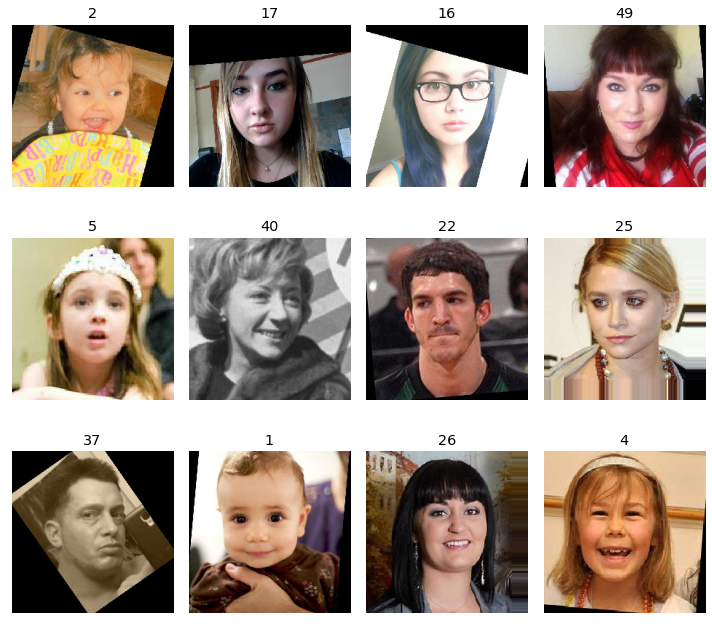

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=IMG_DIR,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

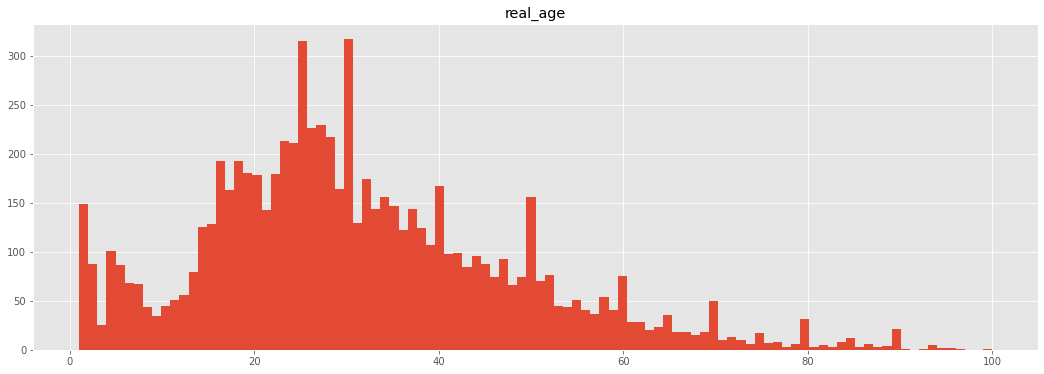

In [5]:
labels.hist(bins=100, figsize=(18,6));

## Prepare Data

In [15]:
# Image augmentation on training data
train_datagen = ImageDataGenerator(validation_split=0.25,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   horizontal_flip=True)

train_data = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=IMG_DIR,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    subset='training')

Found 5694 validated image filenames.


In [16]:
# Image augmentation on validation data
val_datagen = ImageDataGenerator(validation_split=0.25,
                                   rescale=1./255)

val_data = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=IMG_DIR,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    subset='validation')

Found 1897 validated image filenames.


## Train Model

In [17]:
resnet50 = ResNet50(input_shape=(150,150,3),
                    weights='imagenet',
                    include_top=False)

len(resnet50.layers)

175

In [18]:
model = Sequential([resnet50,
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='relu')])

model.compile(loss="mean_squared_error", optimizer=Adam(), metrics=["mean_absolute_error"])

In [19]:
callbacks = EarlyStopping(patience=5, verbose=1)

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=30,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(val_data),
                    verbose=1,
                    callbacks=[callbacks])

Epoch 1/30
178/178 [==============================] - 86s 481ms/step - loss: 236.8218 - mean_absolute_error: 11.8174 - val_loss: 490.7841 - val_mean_absolute_error: 17.0921
Epoch 2/30
178/178 [==============================] - 86s 482ms/step - loss: 159.4055 - mean_absolute_error: 9.7288 - val_loss: 299.8559 - val_mean_absolute_error: 12.8920
Epoch 3/30
178/178 [==============================] - 84s 474ms/step - loss: 138.7994 - mean_absolute_error: 8.9493 - val_loss: 358.0138 - val_mean_absolute_error: 14.1085
Epoch 4/30
178/178 [==============================] - 84s 475ms/step - loss: 120.8358 - mean_absolute_error: 8.3773 - val_loss: 528.9432 - val_mean_absolute_error: 17.4929
Epoch 5/30
178/178 [==============================] - 85s 479ms/step - loss: 104.6946 - mean_absolute_error: 7.8466 - val_loss: 197.7186 - val_mean_absolute_error: 10.5027
Epoch 6/30
178/178 [==============================] - 85s 475ms/step - loss: 96.9867 - mean_absolute_error: 7.5370 - val_loss: 157.0641 - v

In [20]:
model.save("age_detection_model.h5")

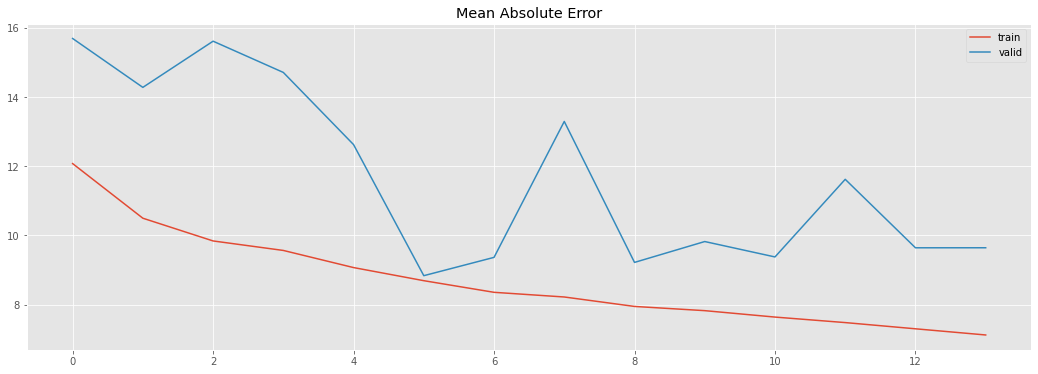

In [14]:
plt.figure(figsize=(18, 6))
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='valid')
plt.legend()
plt.title('Mean Absolute Error')
plt.show()